{'CD8_ex_act', 'CD8_naive', 'CD8_mem', 'CD8_act', 'CD8_eff', 'CD8_ex'}


INFO:tcri.model._model:Unified model: c_count=301, ct_count=523, P=6, global_scale=10.0, local_scale=1.0, use_enumeration=True, sharp_temperature=1.0.


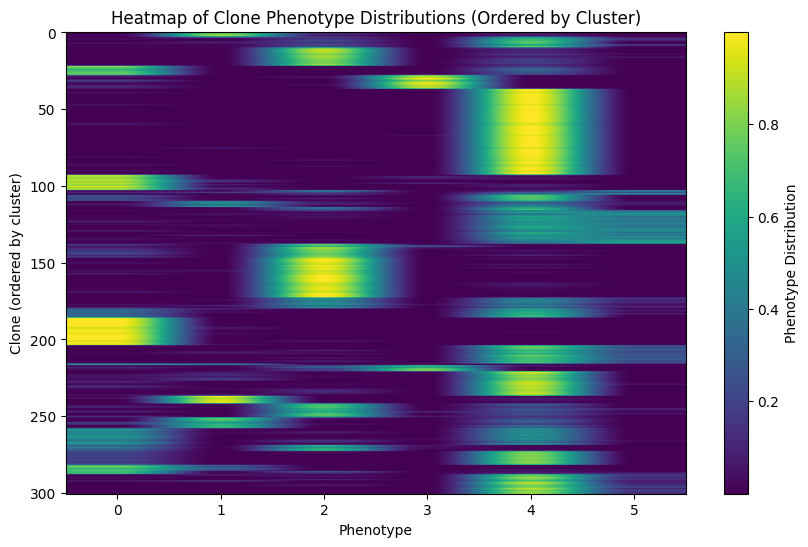

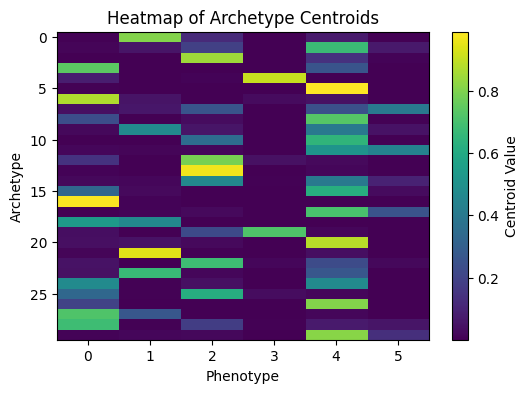

In [57]:
import logging
import numpy as np
import pandas as pd
import torch
import tcri
import scanpy as sc
import os
import warnings
import logging
import pyro
import matplotlib.pyplot as plt
sc._settings.settings._vector_friendly=True


warnings.filterwarnings("ignore", category=UserWarning, message="Found auxiliary vars")
warnings.filterwarnings("ignore", category=UserWarning, message=".*enumerate.*TraceEnum_ELBO.*")

os.environ.pop("SLURM_NTASKS", None)
os.environ.pop("SLURM_NTASKS_PER_NODE", None)
pyro.clear_param_store()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


adata = sc.read("yost_tcri_v2.h5ad")
# adata = adata[adata.obs["disease"] == "scc"]
print(set(adata.obs["cluster"]))

tcri.pp.register_clonotype_key(adata,"trb")
tcri.pp.clone_size(adata)
tcri.pp.group_singletons(adata,min_clone_size=10)

tcri.ml.TCRIModel.setup_anndata(
    adata,
    layer="counts",
    clonotype_key="trb_unique",
    phenotype_key="cluster",
    covariate_key="treatment",
    batch_key="patient",
)

model = tcri.ml.TCRIModel(
    adata,
    n_latent=128,                # Size of the latent space
    n_hidden=128,                # Size of hidden layers in encoder/decoder
    global_scale=10.0,            # Global scaling factor for the clonotype-level prior
    local_scale=1.,             # Local scaling factor for the ct-level prior
    use_enumeration=True,        # Whether to use enumeration in the model
    n_layers=3,                   # Number of layers in the encoder/decoder networks
    classifer_dropout=0.1,
    classifier_hidden=64,
    classifier_n_layers=2,
    classifier_n_heads=4,
    K=30,
    gate_prob=0.5,
    kl_weight=0.5,
    patience=300
)

order = np.argsort(model.labels)
ordered_mat = model.c2p_mat[order, :]

# Plot heatmap of the clone phenotype distributions
plt.figure(figsize=(10, 6))
plt.imshow(ordered_mat, aspect='auto', cmap='viridis')
plt.colorbar(label='Phenotype Distribution')
plt.title('Heatmap of Clone Phenotype Distributions (Ordered by Cluster)')
plt.xlabel('Phenotype')
plt.ylabel('Clone (ordered by cluster)')
plt.show()

# Plot heatmap of the archetype centroids
plt.figure(figsize=(6, 4))
plt.imshow(model.centers, aspect='auto', cmap='viridis')
plt.colorbar(label='Centroid Value')
plt.title('Heatmap of Archetype Centroids')
plt.xlabel('Phenotype')
plt.ylabel('Archetype')
plt.show()


In [58]:
torch.cuda.empty_cache()
model.train(
    max_epochs=1000000,            # Total number of training epochs
    batch_size=5000000,           # Batch size for training
    margin_scale=0.00,
    margin_value=0.00,
    adaptive_margin=False,
    lr=1e-3,                   # Learning rate for the optimizer
    n_steps_kl_warmup=2000,
    reconstruction_loss_scale=7e-3,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using Enumeration


Training:   0%|          | 0/1000000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 300 records. Best score: 8494.273. Signaling Trainer to stop.


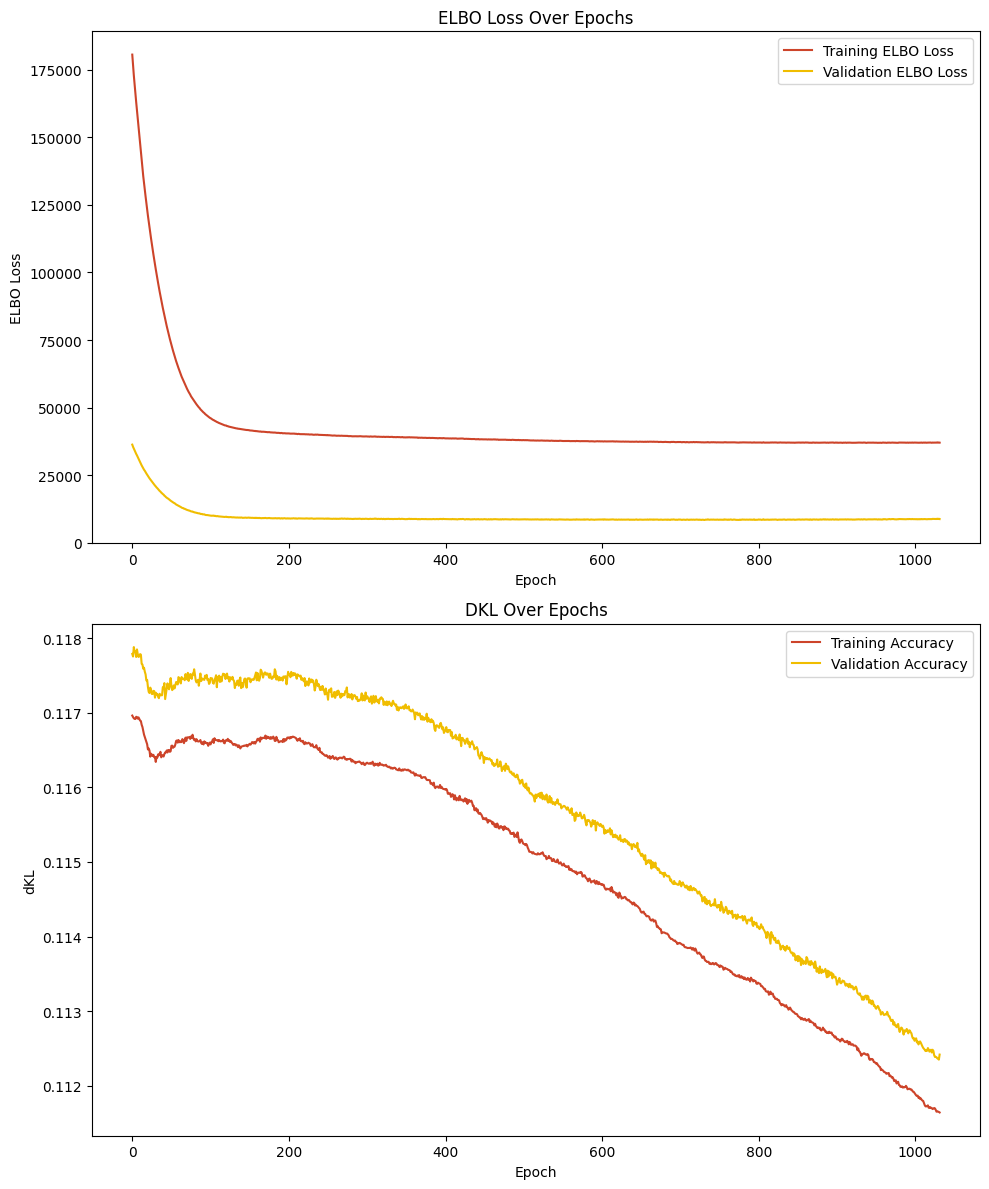

In [59]:
def plot_loss(self, log_scale=False):
    # Retrieve loss and accuracy history
    loss_history = self.history_.get("elbo_train", [])
    loss_validation = self.history_.get("elbo_validation", [])
    train_accuracy = self.history_.get("kl_divergence_with_prior_train_epoch", [])
    val_accuracy = self.history_.get("kl_divergence_with_prior_val", [])

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot ELBO loss
    axes[0].plot(loss_history, label="Training ELBO Loss")
    axes[0].plot(loss_validation, label="Validation ELBO Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("ELBO Loss")
    axes[0].set_title("ELBO Loss Over Epochs")
    axes[0].legend()

    # Plot Accuracy
    if len(train_accuracy) > 0 or len(val_accuracy) > 0:
        if len(train_accuracy) > 0:
            axes[1].plot(train_accuracy, label="Training Accuracy")
        if len(val_accuracy) > 0:
            axes[1].plot(val_accuracy, label="Validation Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("dKL")
        axes[1].set_title("DKL Over Epochs")
        axes[1].legend()

    # Apply log scale if requested
    if log_scale:
        for ax in axes:
            ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

plot_loss(model)


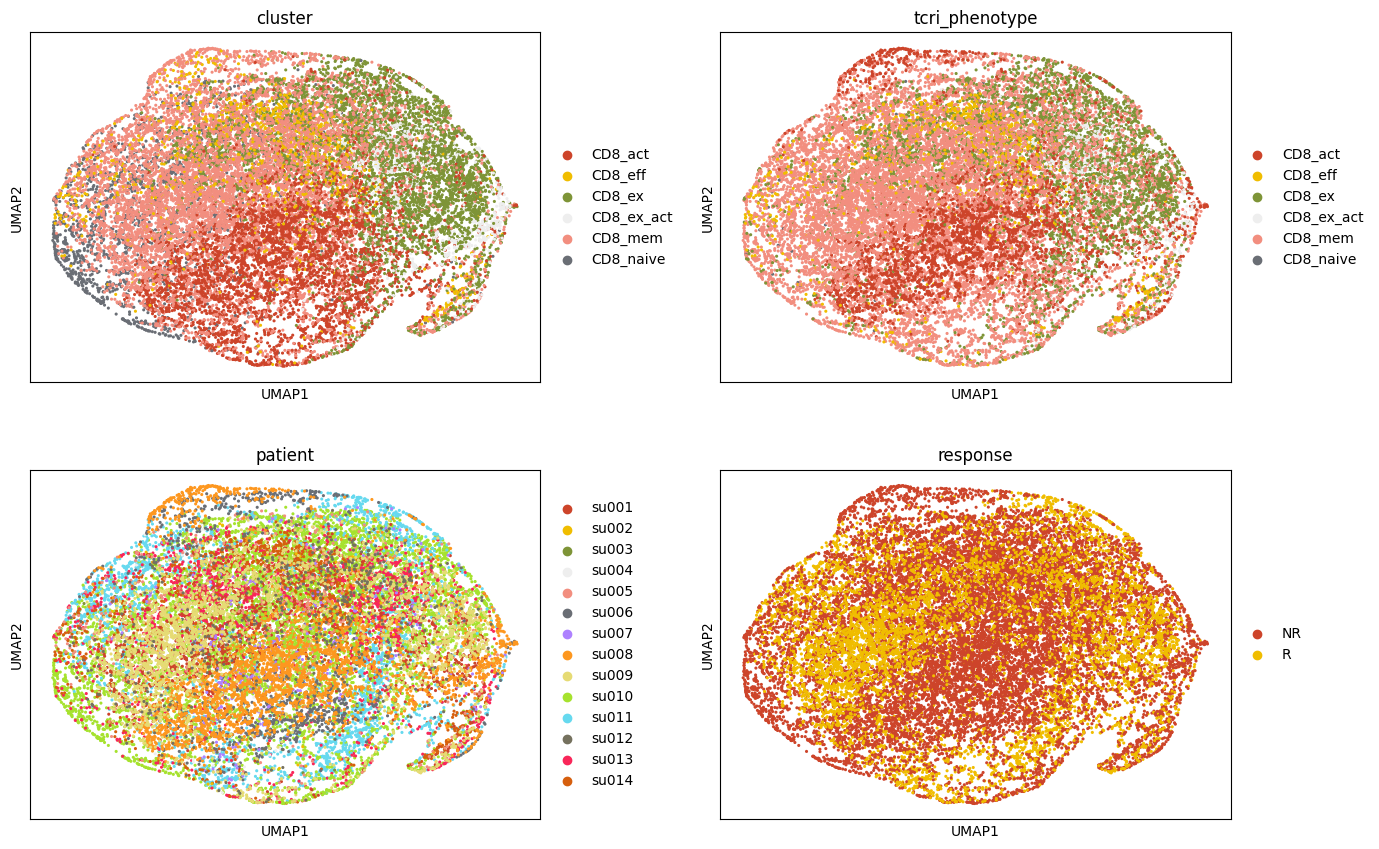

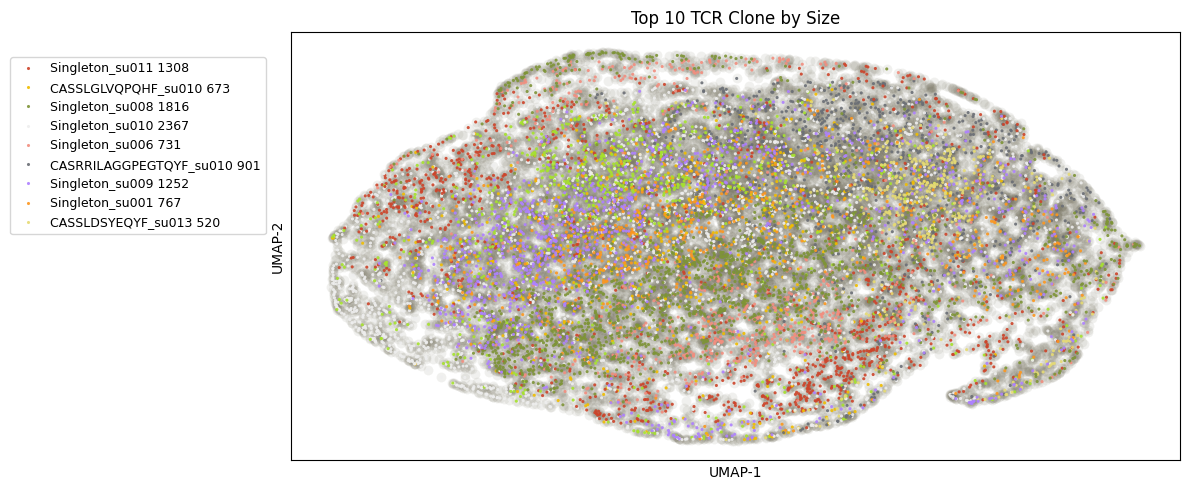

In [162]:
tcri.pp.register_model(adata,model,gate_prob=0.5)
tcri.pp.register_phenotype_key(adata,"tcri_phenotype")
tcri.pp.register_clonotype_key(adata,"trb_unique")

sc.pp.neighbors(adata, use_rep="X_tcri")
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cluster","tcri_phenotype","patient","response"],palette=tcri.pl.tcri_colors,wspace=0.23,s=20,ncols=2,save="yost.pdf")
tcri.pl.top_clone_umap(adata,fg_size=5,bg_size=50,bg_alpha=0.1)

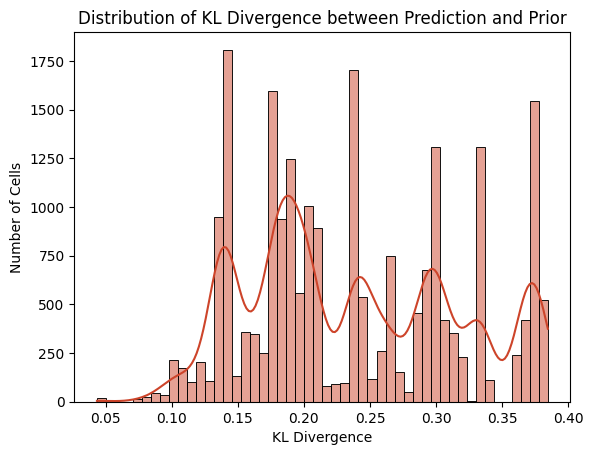

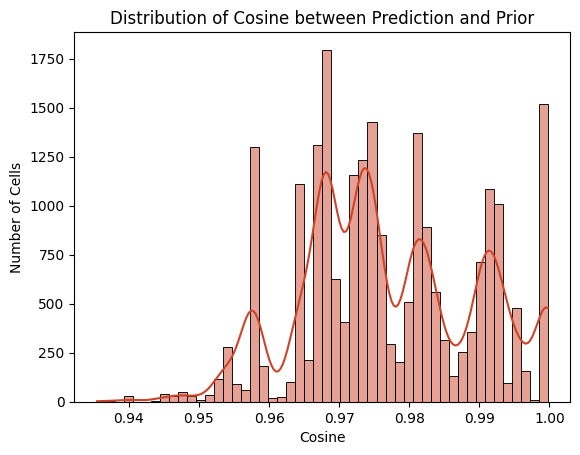

In [83]:
import torch
import numpy as np
import pandas as pd
from scipy.special import rel_entr  # KL divergence

def compare_tcri_predictions_to_prior(
    adata,
    phenotype_prob_slot="X_tcri_phenotypes",
    p_ct_key="tcri_p_ct",
    ct_index_key="tcri_ct_array_for_cells",
    method="kl",
    return_dataframe=False
):
    """
    Compare the predicted phenotype probabilities to the p_ct prior for each cell.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with registered TCRI model outputs.
    phenotype_prob_slot : str
        Key in .obsm where predicted cell phenotype probabilities are stored.
    p_ct_key : str
        Key in .uns where the prior p_ct matrix is stored.
    ct_index_key : str
        Key in .uns where the per-cell clonotype-timepoint (ct) index is stored.
    method : str
        Comparison metric: "kl" (KL divergence), "cosine" (cosine similarity), or "l1" (L1 norm).
    return_dataframe : bool
        If True, returns a DataFrame with scores per cell.
        
    Returns
    -------
    scores : np.ndarray or pd.DataFrame
        A vector of similarity scores between prediction and prior for each cell.
    """
    # Load model predictions and priors
    pred_probs = adata.obsm[phenotype_prob_slot]  # shape (n_cells, P)
    p_ct = adata.uns[p_ct_key]                   # shape (ct_count, P)
    ct_index = adata.uns[ct_index_key]           # shape (n_cells,)

    # Check shapes
    assert pred_probs.shape[0] == ct_index.shape[0], "Mismatch in number of cells"
    assert p_ct.shape[1] == pred_probs.shape[1], "Mismatch in number of phenotype categories"

    # Get the prior for each cell
    prior_probs = p_ct[ct_index]

    # Choose comparison metric
    if method == "kl":
        scores = np.sum(rel_entr(pred_probs + 1e-8, prior_probs + 1e-8), axis=1)  # KL(pred || prior)
    elif method == "cosine":
        scores = np.sum(pred_probs * prior_probs, axis=1) / (
            np.linalg.norm(pred_probs, axis=1) * np.linalg.norm(prior_probs, axis=1) + 1e-8
        )
    elif method == "l1":
        scores = np.sum(np.abs(pred_probs - prior_probs), axis=1)
    else:
        raise ValueError("Invalid method. Choose 'kl', 'cosine', or 'l1'.")

    if return_dataframe:
        return pd.DataFrame({
            "cell": adata.obs_names,
            "ct_index": ct_index,
            "score": scores
        })
    return scores

kl_scores = compare_tcri_predictions_to_prior(adata, method="kl")
cosine_sim = compare_tcri_predictions_to_prior(adata, method="cosine")
import seaborn as sns
import matplotlib.pyplot as plt

def plot_comparison_scores(scores, method="KL Divergence"):
    sns.histplot(scores, bins=50, kde=True)
    plt.xlabel(method)
    plt.ylabel("Number of Cells")
    plt.title(f"Distribution of {method} between Prediction and Prior")
    plt.show()
plot_comparison_scores(kl_scores)
plot_comparison_scores(cosine_sim,method="Cosine")

In [61]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

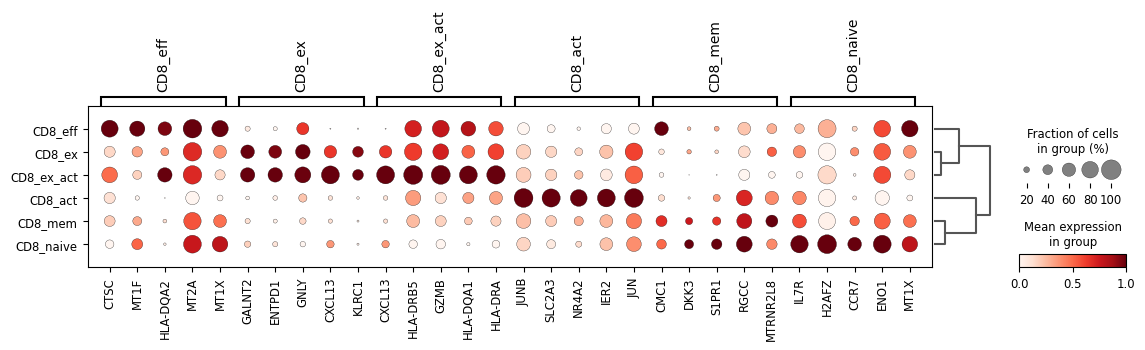

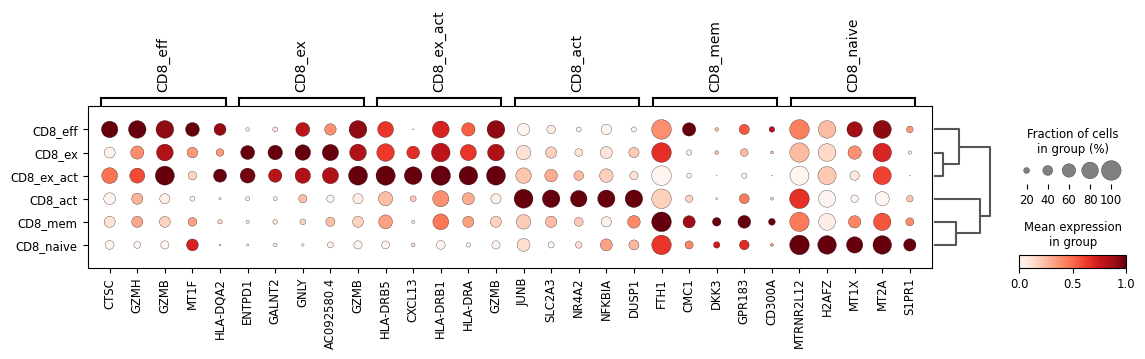

In [62]:
sc.tl.rank_genes_groups(adata,"tcri_phenotype")
sc.pl.rank_genes_groups_dotplot(adata,standard_scale="var",n_genes=5)
sc.tl.rank_genes_groups(adata,"cluster")
sc.pl.rank_genes_groups_dotplot(adata,standard_scale="var",n_genes=5)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from tcri.pl import tcri_colors
from tcri.tl import phenotypic_entropy as pentropy
from scipy.stats import entropy

def pentropy(adata, covariate, clonotype, base=2, normalized=True, temperature=1.0, n_samples=0, clones=None):
    """
    Calculate the phenotypic entropy for a given clonotype and covariate.
    
    This function measures the diversity or uncertainty in the distribution of phenotypes
    for a specific TCR clonotype within a given covariate condition. Higher entropy indicates
    that the clonotype is associated with a broader range of phenotypes.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing the data with TCR and phenotype information
    covariate : str
        The covariate label (e.g., "Day0", "tumor") to calculate entropy for
    clonotype : str
        The clonotype ID for which to calculate phenotypic entropy
    base : int, default=2
        The base of the logarithm used for entropy calculation (base 2 gives entropy in bits)
    normalized : bool, default=True
        If True, normalizes the entropy by the maximum possible entropy (log of the number of phenotypes)
    temperature : float, default=1.0
        Temperature parameter for softening/sharpening distributions
    n_samples : int, default=0
        Number of samples to use for Monte Carlo estimation. If 0, uses point estimates
    clones : list, optional
        List of clone IDs to restrict the analysis to. If None, uses all clones
        
    Returns
    -------
    float
        The phenotypic entropy value for the specified clonotype
    """
    logf = lambda x : np.log(x) / np.log(base)
    jd = joint_distribution(adata, covariate, temperature=temperature, n_samples=n_samples, clones=clones)
    if n_samples > 0:
        jd["clonotype_id"] = ["_".join(x.split("_")[:-1]) for x in jd.index]
        jd = jd.groupby("clonotype_id").mean()
    res = jd.loc[clonotype].to_numpy()
    pent = entropy(res, base=base)
    if normalized:
        pent = pent / logf(len(res))
    return pent

def phenotypic_entropies(adata, covariate, base=2, normalized=True, temperature=1., clones=None, n_samples=0):
    tcr_sequences = adata.obs[adata.uns["tcri_clone_key"]].tolist()
    if clones != None:
        tcr_sequences = [x for x in tcr_sequences if x in clones]
    unique_tcrs = np.unique(tcr_sequences)
    tcr_to_entropy_dict = {
        tcr: pentropy(
            adata, 
            covariate, 
            tcr, 
            base=base, 
            normalized=normalized, 
            temperature=temperature,
            n_samples=n_samples
        ) 
        for tcr in unique_tcrs
    }
    return tcr_to_entropy_dict

def phenotypic_entropy(
    adata,
    splitby=None,
    temperature=1,
    n_samples=0,
    normalized=True,
    palette=None,
    save=None,
    legend_fontsize=6,
    bbox_to_anchor=(1.15, 1.),
    figsize=(10, 4),
    rotation=90,
    bayesian=True,
    bayes_samples=1000,
    return_df=False
):
    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]
    phenotype_col = adata.uns["tcri_metadata"]["phenotype_col"]
    batch_col = adata.uns["tcri_metadata"]["batch_col"]

    if palette is None:
        palette = tcri_colors

    covs = adata.obs[cov_col].astype("category").cat.categories.tolist()
    phenotypes = adata.obs[phenotype_col].astype("category").cat.categories.tolist()
    batches = adata.obs[batch_col].astype("category").cat.categories.tolist()

    ent_vals, ps, ts, phs, splits = [], [], [], [], []

    if splitby:
        split_levels = sorted(adata.obs[splitby].dropna().unique().tolist())
    else:
        split_levels = [None]

    for s in tqdm.tqdm(split_levels, desc="Computing phenotypic entropy"):
        sub_adata = adata[adata.obs[splitby] == s] if s is not None else adata
        for p in sub_adata.obs[batch_col].unique():
            sub = sub_adata[sub_adata.obs[batch_col] == p].copy()
            for t in covs:
                subt = sub[sub.obs[cov_col] == t]
                vclones = list(set(subt.obs[clone_col]))
                if len(vclones) == 0: continue
                for _ in range(n_samples):
                    val = phenotypic_entropies(
                        subt, t,
                        temperature=temperature,
                        clones=vclones,
                        n_samples=1,
                        normalized=normalized
                    )
                    ent_vals.append(np.mean(list(val.values()))) #mean over all clones
                    ps.append(p)
                    ts.append(t)
                    phs.append(ph)
                    splits.append(s)

    df = pd.DataFrame({
        cov_col: ts,
        batch_col: ps,
        "Phenotypic Entropy": ent_vals,
        "Group": splits if splitby else ["All"] * len(ent_vals)
    })

    if bayesian:
        fig, axs = plt.subplots(1, len(split_levels), figsize=(figsize[0], figsize[1]), sharey=True)
        if len(split_levels) == 1:
            axs = [axs]

        results = {}

        for ax, level in zip(axs, split_levels):
            df_level = df[df["Group"] == level]
            entropies = {t: df_level[df_level[cov_col] == t]["Phenotypic Entropy"].values for t in covs}
            d1, d2 = entropies[covs[0]], entropies[covs[1]]

            samples1 = np.random.choice(d1, (bayes_samples, len(d1)), replace=True).mean(axis=1)
            samples2 = np.random.choice(d2, (bayes_samples, len(d2)), replace=True).mean(axis=1)
            delta = samples2 - samples1

            delta_mean = delta.mean()
            delta_std = delta.std()
            hdi_low, hdi_high = np.percentile(delta, [2.5, 97.5])
            p_greater = np.mean(delta > 0)
            cohens_d = delta_mean / delta_std

            results[level] = {
                "delta_mean": delta_mean,
                "delta_std": delta_std,
                "cohens_d": cohens_d,
                "p_greater": p_greater,
                "p_less": 1 - p_greater,
                "hdi": (hdi_low, hdi_high),
                "delta_samples": delta
            }

            sns.kdeplot(delta, fill=True, ax=ax, alpha=0.4)
            ax.axvline(0, color="k", linestyle="--")
            ax.set_title(f"{level}\nΔ={delta_mean:.2f}, P(Δ>0)={p_greater:.2f}")
            ax.set_xlabel("Δ Phenotypic Entropy")
            ax.set_ylabel("Posterior Density")

        fig.suptitle("Posterior Δ Phenotypic Entropy (Bayesian)", fontsize=14)
        fig.tight_layout()

        if save:
            fig.savefig(save, dpi=150)
        plt.show()

        if return_df:
            return df, results
        return results

    else:
        # Classical plot for fallback (box + strip)
        fig, ax = plt.subplots(figsize=figsize)
        if splitby:
            sns.boxplot(data=df, x="Group", y="Phenotypic Entropy", hue=cov_col, palette=palette)
            sns.stripplot(data=df, x="Group", y="Phenotypic Entropy", hue=cov_col, palette="dark:.2", dodge=True)
        else:
            sns.boxplot(data=df, x=cov_col, y="Phenotypic Entropy", color="#999999")
            sns.stripplot(data=df, x=cov_col, y="Phenotypic Entropy", palette=palette, dodge=False)

        ax.set_title("Phenotypic Entropy")
        ax.set_xlabel("Covariate")
        ax.set_ylabel("Entropy")
        plt.xticks(rotation=rotation)
        plt.tight_layout()
        if save:
            fig.savefig(save, dpi=150)
        plt.show()

        if return_df:
            return df
_ = phenotypic_entropy(adata,n_samples=100, temperature=.1, splitby="response",normalized=True)

Computing phenotypic entropy:   0%|          | 0/2 [00:00<?, ?it/s]

Computing mutual information: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


R 0.30553188812338006 16.5
NR 0.898103811758924 23.0


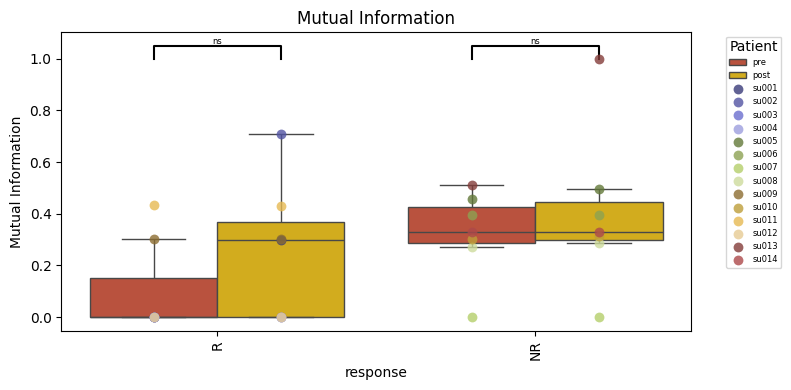

,treatment,patient,Mutual Information,response,_x
0,post,su001,2.985017e-01,R,0.2
1,pre,su001,-1.035439e-07,R,-0.2
2,post,su002,7.070598e-01,R,0.2
3,pre,su002,0.000000e+00,R,-0.2
4,post,su003,0.000000e+00,R,0.2
5,pre,su003,0.000000e+00,R,-0.2
6,post,su004,0.000000e+00,R,0.2
7,pre,su004,0.000000e+00,R,-0.2
8,post,su005,4.965836e-01,NR,1.2
9,pre,su005,4.587523e-01,NR,0.8


In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.utils import Phenotypes, CellRepertoire, Tcell, plot_pheno_sankey, plot_pheno_ternary_change_plots, draw_clone_bars, probabilities, set_ternary_corner_label, ternary_plot_projection
from tcri.pp import clone_size, joint_distribution
from tcri.metrics import clonotypic_entropy as centropy
from tcri.metrics import phenotypic_entropy as pentropy
from tcri.metrics import clonality as clonality_tl
from tcri.metrics import flux as flux_tl
from tcri.metrics import mutual_information as mutual_information_tl
from tcri.metrics import clone_fraction as clone_fraction_tl

from scipy.stats import mannwhitneyu
from tcri.pl import tcri_colors

import numpy as np

def mutual_information_tl(
    adata, 
    covariate,
    temperature=1.0,
    n_samples=0,
    clones=None,
    weighted=False,
    normalized=True,
    normalize_mode="average"  # or "min"
):
    """
    Compute mutual information I(C;P) between clonotype (C) and phenotype (P)
    Optionally normalized by average or min entropy: NMI = I(C;P) / f(H(C), H(P))
    """
    # Get joint distribution matrix
    pxy_df = joint_distribution(
        adata=adata,
        covariate_label=covariate,
        temperature=temperature,
        n_samples=n_samples,
        clones=clones,
        weighted=weighted
    )

    if n_samples > 0:
        pxy_df["clone"] = ["_".join(x.split("_")[:2]) for x in pxy_df.index]
        pxy_df = pxy_df.groupby("clone").median()

    pxy = pxy_df.to_numpy()
    
    # Normalize to get valid joint distribution
    total = pxy.sum()
    if total < 1e-15:
        return 0.0
    pxy /= total

    # Marginals
    px = pxy.sum(axis=1, keepdims=True)  # shape (n_clones, 1)
    py = pxy.sum(axis=0, keepdims=True)  # shape (1, n_pheno)

    # Product of marginals
    px_py = px @ py

    # Compute MI
    eps = 1e-15
    mask = pxy > eps
    mi = np.sum(pxy[mask] * np.log2((pxy[mask] + eps) / (px_py[mask] + eps)))

    if not normalized:
        return mi

    # Compute entropies
    h_c = -np.sum(px[px > eps] * np.log2(px[px > eps]))
    h_p = -np.sum(py[py > eps] * np.log2(py[py > eps]))

    if normalize_mode == "min":
        denom = min(h_c, h_p)
    else:  # "average"
        denom = 0.5 * (h_c + h_p)

    return mi / denom if denom > 0 else 0.0


def mutual_information(adata, splitby=None, temperature=1.0, n_samples=0, normalized=True, 
                       palette=None, save=None, legend_fontsize=6, bbox_to_anchor=(1.15,1.), 
                       figsize=(8,4), rotation=90, weighted=True, return_plot=True):
    """
    Compute and plot mutual information between clonotypes and phenotypes.
    
    This function calculates mutual information between TCR clonotypes and cell phenotypes,
    which quantifies how much information one variable provides about the other. The function
    can optionally split the calculation by a specified categorical variable (e.g., timepoint,
    condition). Results are displayed as a box plot with individual data points.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing the data with TCR and phenotype information
    splitby : str, optional
        Column name to split the data by. If None, uses the covariate column stored in adata.uns["tcri_metadata"]
    temperature : float, default=1.0
        Temperature parameter for softening/sharpening distributions in the joint distribution calculation
    n_samples : int, default=0
        Number of samples to use for Monte Carlo estimation of mutual information
    normalized : bool, default=True
        Whether to normalize the mutual information values to [0,1] range
    palette : list, optional
        Color palette for the plot. If None, uses tcri_colors
    save : str, optional
        Path to save the plot figure
    legend_fontsize : int, default=6
        Font size for the plot legend
    bbox_to_anchor : tuple, default=(1.15,1.)
        Position of the legend box
    figsize : tuple, default=(8,4)
        Size of the figure in inches (width, height)
    rotation : int, default=90
        Rotation angle for x-axis labels
    weighted : bool, default=True
        Whether to weight the mutual information by clone size
    return_plot : bool, default=True
        Whether to return the plot axis. If False, returns only the DataFrame with MI values
        
    Returns
    -------
    Union[matplotlib.axes.Axes, pd.DataFrame]
        If return_plot is True, returns the plot axis. Otherwise returns a DataFrame with MI values.
        
    Examples
    --------
    >>> import tcri
    >>> # Calculate and plot mutual information
    >>> ax = tcri.pl.mutual_information(adata, splitby="timepoint", temperature=1.0)
    >>> 
    >>> # Get the mutual information values as a DataFrame without plotting
    >>> mi_df = tcri.pl.mutual_information(adata, splitby="condition", return_plot=False)
    """
    if palette is None:
        palette = tcri_colors

    # Retrieve metadata from adata
    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]
    phenotype_col = adata.uns["tcri_metadata"]["phenotype_col"]
    batch_col = adata.uns["tcri_metadata"]["batch_col"]
    
    covs = adata.obs[cov_col].astype("category").cat.categories.tolist()
    batches = adata.obs[batch_col].astype("category").cat.categories.tolist()

    mi_vals = []
    ps = []
    ts = []
    cl = []

    for p in tqdm.tqdm(batches, desc="Computing mutual information"):
        sub = adata[adata.obs[batch_col] == p].copy()
        for t in covs:
            subt = sub[sub.obs[cov_col] == t]
            # figure out which clones are actually present
            vclones = list(set(subt.obs[clone_col]))
            
            if splitby is None:
                # Compute MI for all clones in cov t, batch p
                val = mutual_information_tl(
                    subt, t, 
                    temperature=temperature, 
                    clones=vclones,
                    n_samples=n_samples,
                    weighted=weighted
                )
                mi_vals.append(val)
                ps.append(p)
                ts.append(t)

            else:
                # If you want to split further by some obs column
                for s in sorted(subt.obs[splitby].unique()):
                    subts = subt[subt.obs[splitby] == s]
                    vclones2 = list(set(subts.obs[clone_col]))
                    val = mutual_information_tl(
                        subts, t,
                        temperature=temperature,
                        clones=vclones2,
                        n_samples=n_samples,
                        weighted=weighted
                    )
                    mi_vals.append(val)
                    ps.append(p)
                    ts.append(t)
                    cl.append(s)

    # Build a DataFrame for plotting
    if splitby is None:
        df = pd.DataFrame({
            cov_col: ts,
            batch_col: ps,
            "Mutual Information": mi_vals
        })
    else:
        df = pd.DataFrame({
            cov_col: ts,
            batch_col: ps,
            "Mutual Information": mi_vals,
            splitby: cl
        })

    ret_df = df
    # 1) define your x‑ and hue‑levels
    x_cats   = df[splitby].unique().tolist()
    hue_order = ["pre", "post"]
    cov_cats = hue_order
    
    # 2) compute dodge offsets exactly like seaborn
    n_cov      = len(cov_cats)
    total_w    = 0.8
    step_w     = total_w / n_cov
    offsets    = np.linspace(-total_w/2 + step_w/2,
                             total_w/2 - step_w/2,
                             n_cov)
    cov2off    = dict(zip(cov_cats, offsets))
    
    # 3) add a numeric x‑position for your scatter
    df["_x"] = df[splitby].map(lambda x: x_cats.index(x)) + df[cov_col].map(cov2off)
    
    # 4) start the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.boxplot(
        data=df,
        x=splitby, y="Mutual Information", hue=cov_col,
        palette=palette,
        hue_order=["pre","post"],
        ax=ax, width=total_w, fliersize=0,
        zorder=1
    )
    ax.legend_.remove()
    
    # 5) compute all covariate‑pairs and global y positions
    pairs = list(itertools.combinations(cov_cats, 2))
    y_max   = df["Mutual Information"].max()
    y_min   = df["Mutual Information"].min()
    yrange  = y_max - y_min
    h_bar   = yrange * 0.05
    v_step  = h_bar * 1.2
    
    # 6) for each x‑category, annotate each pair
    for i, xcat in enumerate(x_cats):
        for j, (g1, g2) in enumerate(pairs):
            # slice data for the two levels
            d1 = df[(df[splitby] == xcat) & (df[cov_col] == g1)]["Mutual Information"]
            d2 = df[(df[splitby] == xcat) & (df[cov_col] == g2)]["Mutual Information"]
            if len(d1)==0 or len(d2)==0:
                continue
    
            # Mann–Whitney U test
            stat, p = mannwhitneyu(d1, d2)
            stars = ("ns" if p>=0.05 else
                     "*"  if p<0.05  else
                     "**" if p<0.01  else
                     "***" if p<0.001 else "****")
            print(xcat,p,stat)
            # x‑positions of the two boxes
            x1 = i + cov2off[g1]
            x2 = i + cov2off[g2]
    
            # vertical position for this bar
            y = y_max + j * v_step
    
            # draw the bracket
            ax.plot([x1, x1, x2, x2],
                    [y,   y+h_bar, y+h_bar, y],
                    lw=1.5, c="k", zorder=3)
            # draw the stars
            ax.text((x1+x2)/2, y+h_bar,
                    stars,
                    ha="center", va="bottom",
                    fontsize=legend_fontsize,
                    zorder=4)
    
    # 7) now scatter your patient‑colored points on top
    patients        = df[batch_col].unique().tolist()
    patient_palette = sns.color_palette("tab20b", len(patients))
    patient_colors  = dict(zip(patients, patient_palette))
    
    for pt in patients:
        sub = df[df[batch_col] == pt]
        ax.scatter(
            sub["_x"], sub["Mutual Information"],
            color=patient_colors[pt],
            label=pt,
            s=50, alpha=0.8,
            edgecolor="white", linewidth=0.,
            zorder=10,
        )
    
    ax.legend(
        title="Patient",
        fontsize=legend_fontsize,
        loc="upper right",
        bbox_to_anchor=bbox_to_anchor,
    )
    plt.xticks(range(len(x_cats)), x_cats, rotation=rotation)
    ax.set_xlabel(splitby)
    ax.set_title("Mutual Information" + (" (Weighted)" if weighted else ""))
    fig.tight_layout()
    
    if save:
        plt.savefig(save, dpi=150)
    plt.show()
    return df

ct = []
for x,y in zip(adata.obs["response"],adata.obs["disease"]):
    ct.append("{}-{}".format(x,y))
adata.obs["rd"] =ct
df = mutual_information(adata, temperature=0.1, weighted=False, return_plot=True, splitby="response",n_samples=1000)
df


🔍 response = NR — Δ MI (post - pre)
Δ mean = -0.0244, std = 0.0384
Cohen's d = -0.636
95% HDI: (-0.0889, 0.0523)
P(Δ > 0) = 0.259, P(Δ < 0) = 0.741

🔍 response = R — Δ MI (post - pre)
Δ mean = 0.0696, std = 0.0237
Cohen's d = 2.937
95% HDI: (0.0234, 0.1160)
P(Δ > 0) = 0.997, P(Δ < 0) = 0.003


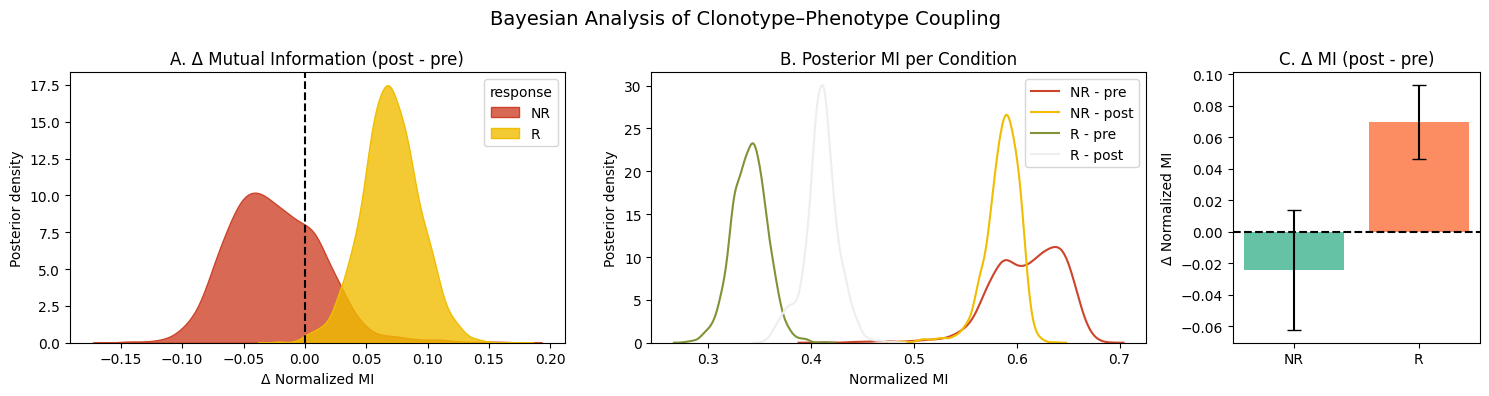

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def bayesian_mi_summary_plot(
    adata,
    group1: str = "pre",
    group2: str = "post",
    splitby: str = "response",
    n_samples: int = 200,
    temperature: float = 1.0,
    normalized: bool = True,
    normalize_mode: str = "average",
    weighted: bool = False,
    seed: int = 42
):
    np.random.seed(seed)

    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]

    groups = sorted(adata.obs[splitby].dropna().unique().tolist())
    results = {}

    for group in groups:
        adata_sub = adata[adata.obs[splitby] == group].copy()
        clones = adata_sub.obs[clone_col].unique().tolist()

        mi_pre, mi_post, delta = [], [], []

        for _ in range(n_samples):
            mi1 = mutual_information_tl(
                adata=adata_sub[adata_sub.obs[cov_col] == group1],
                covariate=group1,
                temperature=temperature,
                n_samples=1,
                clones=clones,
                weighted=weighted,
                normalized=normalized,
                normalize_mode=normalize_mode
            )
            mi2 = mutual_information_tl(
                adata=adata_sub[adata_sub.obs[cov_col] == group2],
                covariate=group2,
                temperature=temperature,
                n_samples=1,
                clones=clones,
                weighted=weighted,
                normalized=normalized,
                normalize_mode=normalize_mode
            )
            mi_pre.append(mi1)
            mi_post.append(mi2)
            delta.append(mi2 - mi1)

        mi_pre = np.array(mi_pre)
        mi_post = np.array(mi_post)
        delta = np.array(delta)

        delta_mean = delta.mean()
        delta_std = delta.std()
        cohens_d = delta_mean / delta_std
        hdi_low, hdi_high = np.percentile(delta, [2.5, 97.5])
        p_greater = np.mean(delta > 0)
        p_less = np.mean(delta < 0)

        print(f"\n🔍 {splitby} = {group} — Δ MI ({group2} - {group1})")
        print(f"Δ mean = {delta_mean:.4f}, std = {delta_std:.4f}")
        print(f"Cohen's d = {cohens_d:.3f}")
        print(f"95% HDI: ({hdi_low:.4f}, {hdi_high:.4f})")
        print(f"P(Δ > 0) = {p_greater:.3f}, P(Δ < 0) = {p_less:.3f}")

        results[group] = {
            "delta_samples": delta,
            "mi_pre_samples": mi_pre,
            "mi_post_samples": mi_post,
            "delta_mean": delta_mean,
            "delta_std": delta_std,
            "cohens_d": cohens_d,
            "p_greater": p_greater,
            "p_less": p_less,
            "hdi": (hdi_low, hdi_high)
        }

    # 🎨 Plot panels
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"width_ratios": [2, 2, 1]})

    # Panel A: Posterior ΔMI distributions
    for group in groups:
        sns.kdeplot(results[group]["delta_samples"], fill=True, ax=axs[0], label=group, alpha=0.8)
    axs[0].axvline(0, color="k", linestyle="--")
    axs[0].set_title("A. Δ Mutual Information (post - pre)")
    axs[0].set_xlabel("Δ Normalized MI")
    axs[0].set_ylabel("Posterior density")
    axs[0].legend(title=splitby)

    # Panel B: MI pre/post distributions
    for group in groups:
        sns.kdeplot(results[group]["mi_pre_samples"], label=f"{group} - pre", ax=axs[1])
        sns.kdeplot(results[group]["mi_post_samples"], label=f"{group} - post", ax=axs[1])
    axs[1].set_title("B. Posterior MI per Condition")
    axs[1].set_xlabel("Normalized MI")
    axs[1].set_ylabel("Posterior density")
    axs[1].legend()

    # Panel C: Δ MI summary bars
    labels = []
    means = []
    errors = []
    for group in groups:
        labels.append(group)
        means.append(results[group]["delta_mean"])
        errors.append(results[group]["delta_std"])
    axs[2].bar(labels, means, yerr=errors, capsize=5, color=sns.color_palette("Set2", len(groups)))
    axs[2].axhline(0, color="k", linestyle="--")
    axs[2].set_title("C. Δ MI (post - pre)")
    axs[2].set_ylabel("Δ Normalized MI")

    fig.suptitle("Bayesian Analysis of Clonotype–Phenotype Coupling", fontsize=14)
    fig.tight_layout()
    fig.savefig("bayes_mi_yost.pdf")
    return results

results = bayesian_mi_summary_plot(
    adata=adata,
    group1="pre",
    group2="post",
    splitby="response",
    normalized=True,
    weighted=True,
    n_samples=2000,
    temperature=0.5,
)

Computing clonotypic entropy: 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]


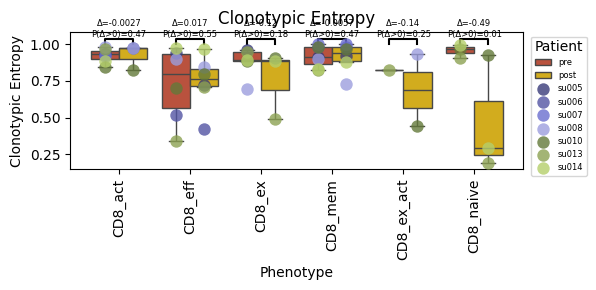

Computing clonotypic entropy: 100%|██████████| 7/7 [00:00<00:00, 15.84it/s]


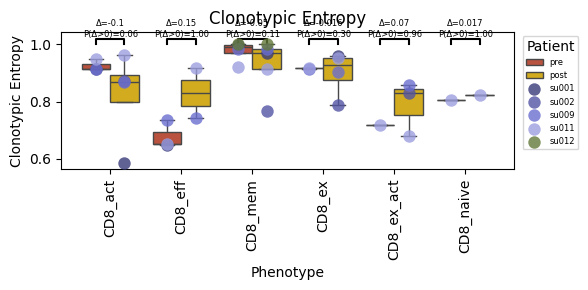

In [165]:
def clonotypic_entropy_by_phenotype(
    adata,
    temperature=1,
    n_samples=0,
    normalized=True,
    palette=None,
    hue_order=None,
    save=None,
    legend_fontsize=6,
    bbox_to_anchor=(1.15, 1.),
    figsize=(6, 3),
    rotation=90,
    return_df=False,
    bayesian=True,  # ✅ NEW FLAG
    bayes_samples=1000
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import tqdm
    from tcri.pl import tcri_colors
    from tcri.tl import clonotypic_entropy as centropy

    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]
    phenotype_col = adata.uns["tcri_metadata"]["phenotype_col"]
    batch_col = adata.uns["tcri_metadata"]["batch_col"]

    if palette is None:
        palette = tcri_colors

    covs = adata.obs[cov_col].astype("category").cat.categories.tolist()
    phenotypes = adata.obs[phenotype_col].astype("category").cat.categories.tolist()
    batches = adata.obs[batch_col].astype("category").cat.categories.tolist()

    if hue_order is None:
        hue_order = covs

    ent_vals = []
    ps, ts, phs = [], [], []

    for p in tqdm.tqdm(batches, desc="Computing clonotypic entropy"):
        sub = adata[adata.obs[batch_col] == p].copy()
        for t in hue_order:
            subt = sub[sub.obs[cov_col] == t]
            for ph in phenotypes:
                subph = subt[subt.obs[phenotype_col] == ph]
                vclones = list(set(subph.obs[clone_col]))
                val = centropy(
                    subph, t, ph,
                    temperature=temperature,
                    clones=vclones,
                    n_samples=n_samples,
                    normalized=normalized
                )
                if abs(val) != 0 and not np.isnan(val):
                    ent_vals.append(val)
                    ps.append(p)
                    ts.append(t)
                    phs.append(ph)

    df = pd.DataFrame({
        cov_col: ts,
        batch_col: ps,
        "Clonotypic Entropy": ent_vals,
        phenotype_col: phs
    })

    x_cats = df[phenotype_col].unique().tolist()

    n_cov = len(hue_order)
    total_w = 0.8
    step_w = total_w / n_cov
    offsets = np.linspace(-total_w / 2 + step_w / 2, total_w / 2 - step_w / 2, n_cov)
    cov2off = dict(zip(hue_order, offsets))
    df["_x"] = df[phenotype_col].map(lambda x: x_cats.index(x)) + df[cov_col].map(cov2off)

    fig, ax = plt.subplots(figsize=figsize)

    sns.boxplot(
        data=df,
        x=phenotype_col,
        y="Clonotypic Entropy",
        hue=cov_col,
        palette=palette,
        hue_order=hue_order,
        ax=ax,
        width=total_w,
        fliersize=0,
        zorder=1
    )
    ax.legend_.remove()

    # 🔁 Bayesian-style posterior annotations
    y_max = df["Clonotypic Entropy"].max()
    y_min = df["Clonotypic Entropy"].min()
    yrange = y_max - y_min
    h_bar = yrange * 0.05
    v_step = h_bar * 1.2

    for i, xcat in enumerate(x_cats):
        for j, (g1, g2) in enumerate(itertools.combinations(hue_order, 2)):
            d1 = df[(df[phenotype_col] == xcat) & (df[cov_col] == g1)]["Clonotypic Entropy"].dropna().values
            d2 = df[(df[phenotype_col] == xcat) & (df[cov_col] == g2)]["Clonotypic Entropy"].dropna().values
            if len(d1) == 0 or len(d2) == 0:
                continue

            if bayesian:
                samples1 = np.random.choice(d1, (bayes_samples, len(d1)), replace=True).mean(axis=1)
                samples2 = np.random.choice(d2, (bayes_samples, len(d2)), replace=True).mean(axis=1)
                delta = samples2 - samples1
                mean = delta.mean()
                hdi_low, hdi_high = np.percentile(delta, [2.5, 97.5])
                p_greater = np.mean(delta > 0)

                label = f"Δ={mean:.2g}\nP(Δ>0)={p_greater:.2f}"
            else:
                from scipy.stats import mannwhitneyu
                stat, pval = mannwhitneyu(d1, d2, alternative="two-sided")
                label = ("ns" if pval >= 0.05 else
                         "*" if pval < 0.05 else
                         "**" if pval < 0.01 else
                         "***" if pval < 0.001 else "****")

            x1 = i + cov2off[g1]
            x2 = i + cov2off[g2]
            y = y_max + j * v_step
            ax.plot([x1, x1, x2, x2], [y, y + h_bar, y + h_bar, y], lw=1.5, c="k", zorder=3)
            ax.text((x1 + x2) / 2, y + h_bar, label, ha="center", va="bottom", fontsize=legend_fontsize, zorder=4)

    # Patient-colored scatter
    patients = df[batch_col].unique().tolist()
    patient_palette = sns.color_palette("tab20b", len(patients))
    patient_colors = dict(zip(patients, patient_palette))

    for pt in patients:
        sub = df[df[batch_col] == pt]
        ax.scatter(
            sub["_x"], sub["Clonotypic Entropy"],
            color=patient_colors[pt],
            label=pt,
            s=80, alpha=0.8,
            edgecolor="white", linewidth=0.,
            zorder=10
        )

    ax.legend(
        title="Patient",
        fontsize=legend_fontsize,
        loc="upper right",
        bbox_to_anchor=bbox_to_anchor
    )
    plt.xticks(range(len(x_cats)), x_cats, rotation=rotation)
    ax.set_xlabel("Phenotype")
    ax.set_title("Clonotypic Entropy")
    fig.tight_layout()

    if save:
        fig.savefig(save, dpi=150)

    plt.show()

    if return_df:
        return df


for x in set(adata.obs["response"]):
    cdata = adata[adata.obs["response"] == x].copy()
    df = clonotypic_entropy_by_phenotype(
        cdata,
        temperature=1,
        hue_order=["pre", "post"],
        bayesian=True,     # ✅ enables posterior comparison
        return_df=True,
        save="yost_ce_{}.pdf".format(x),
    )

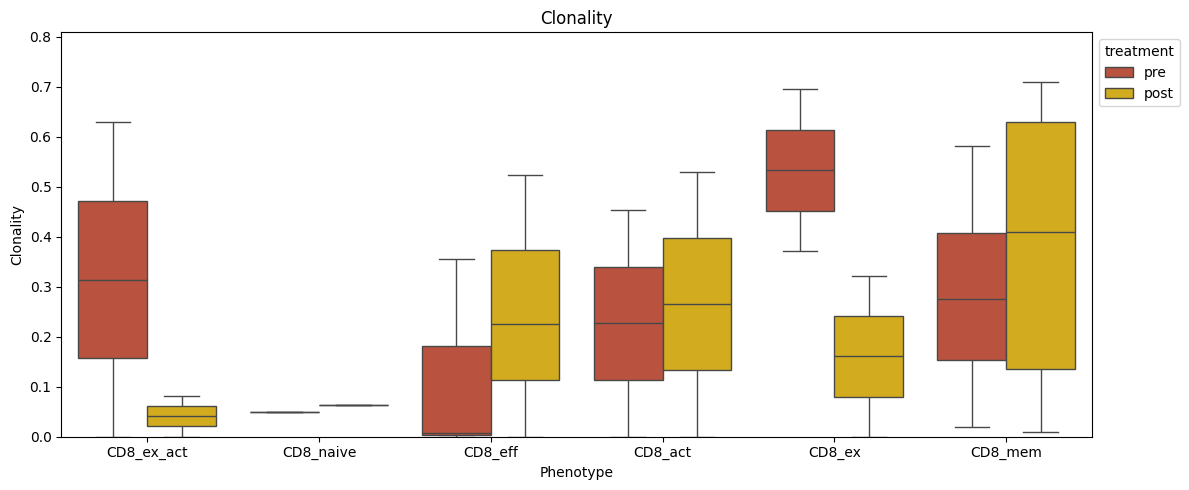

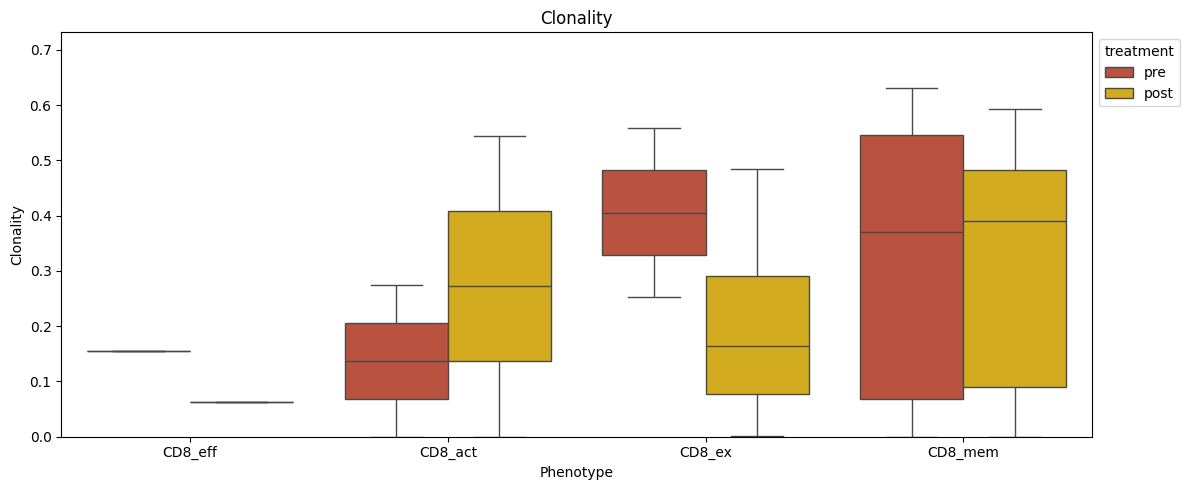

In [16]:
for x in set(adata.obs["response"]):
    cdata = adata[adata.obs["response"] == x].copy()
    tcri.pl.clonality(cdata, groupby="patient", splitby="treatment")

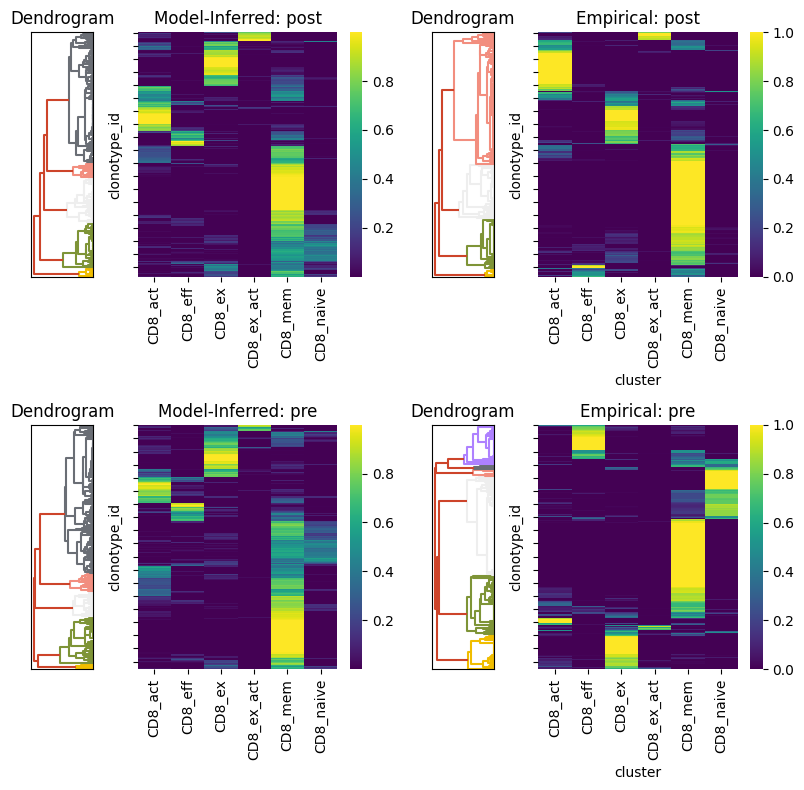

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

# -----------------------------
# 1. Get Model-Inferred Distributions
# -----------------------------
# Create a dictionary mapping each tissue (treatment group) to its clone phenotype DataFrame
model_dists = dict()
for tissue in set(adata.obs["treatment"]):
    # Use your function to get the inferred p_ct distribution (with temperature scaling)
    df_tissue = tcri.pp.joint_distribution(adata,tissue, temperature=1)
    df_tissue["treatment"] = tissue
    # Set clonotype_id as index for easier merging/comparison later
    #df_tissue.set_index("clonotype_id", inplace=True)
    model_dists[tissue] = df_tissue

# Concatenate the inferred distributions from all tissues into a single DataFrame
df_model = pd.concat(model_dists.values(), axis=0)


empirical_dists = dict()
clonotype_col = model.adata_manager.registry["clonotype_col"]
phenotype_col = model.adata_manager.registry["phenotype_col"]

for tissue in set(adata.obs["treatment"]):
    # Filter for cells in the given tissue
    adata_tissue = adata[adata.obs["treatment"] == tissue].copy()
    # Group by clonotype and compute normalized counts of each phenotype
    emp = (
        adata_tissue.obs.groupby(clonotype_col)[phenotype_col]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    # Ensure that the DataFrame uses the actual phenotype category names as columns.
    # If some phenotype categories are missing in a tissue, add them with 0.
    phenotype_categories = list(adata.obs[phenotype_col].astype("category").cat.categories)
    for ph in phenotype_categories:
        if ph not in emp.columns:
            emp[ph] = 0.0
    # Reorder columns
    emp = emp[phenotype_categories]
    emp["treatment"] = tissue
    # Use clonotype ID (from the index) as a column if needed
    emp.index.name = "clonotype_id"
    empirical_dists[tissue] = emp

# Concatenate the empirical distributions from all tissues into one DataFrame.
df_empirical = pd.concat(empirical_dists.values(), axis=0)

# -----------------------------
# 3. Compare Distributions: Plotting Side-by-Side
# -----------------------------
# We’ll loop over the unique tissues and for each, plot the inferred (model) and empirical distributions.
unique_tissues = df_model["treatment"].unique()
n_tissues = len(unique_tissues)

fig, axes = plt.subplots(n_tissues, 4, figsize=(8, 8),
                         gridspec_kw={'width_ratios': [1, 4, 1, 4]})

# In case there's only one tissue, ensure axes is 2D.
if n_tissues == 1:
    axes = np.expand_dims(axes, axis=0)

for i, tissue in enumerate(unique_tissues):
    # Select the rows for the current tissue for both distributions
    model_data = df_model[df_model["treatment"] == tissue]
    empirical_data = df_empirical[df_empirical["treatment"] == tissue]
    
    # Determine the phenotype columns (assumed to be common to both)
    phenotype_cols = [col for col in model_data.columns if col not in ["clonotype_index", "treatment"]]
    
    # --- Model-Inferred Distribution ---
    # Compute hierarchical clustering for the model distribution.
    Z_model = linkage(model_data[phenotype_cols], method='average')
    dendro_model = dendrogram(Z_model, orientation='left', ax=axes[i, 0], no_labels=True)
    # Order the data
    ordered_model = model_data.iloc[dendro_model['leaves']]
    sns.heatmap(ordered_model[phenotype_cols], ax=axes[i, 1], cmap="viridis", cbar=True)
    axes[i, 1].set_title(f"Model-Inferred: {tissue}")
    axes[i, 0].set_title("Dendrogram")
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticklabels([])
    
    # --- Empirical Distribution ---
    # Compute hierarchical clustering for the empirical distribution.
    Z_emp = linkage(empirical_data[phenotype_cols], method='average')
    dendro_emp = dendrogram(Z_emp, orientation='left', ax=axes[i, 2], no_labels=True)
    ordered_emp = empirical_data.iloc[dendro_emp['leaves']]
    sns.heatmap(ordered_emp[phenotype_cols], ax=axes[i, 3], cmap="viridis", cbar=True)
    axes[i, 3].set_title(f"Empirical: {tissue}")
    axes[i, 2].set_title("Dendrogram")
    axes[i, 2].set_xticks([])
    axes[i, 2].set_yticks([])
    axes[i, 3].set_yticklabels([])

plt.tight_layout()
plt.savefig("jd_comparison.pdf")


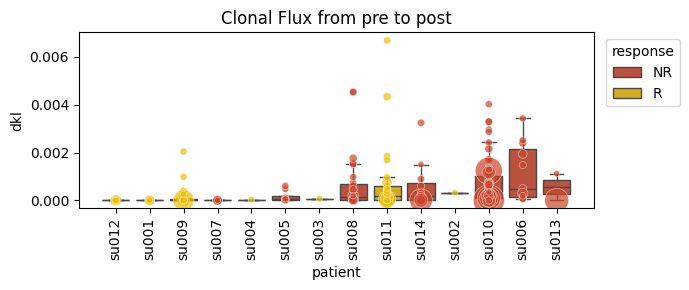

In [170]:
def clonal_flux(adata, from_this, to_that, splitby, distance_metric="dkl", rotation=90, temperature=1, figsize=(7,2)):
    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]
    phenotype_col = adata.uns["tcri_metadata"]["phenotype_col"]
    batch_col = adata.uns["tcri_metadata"]["batch_col"]

    clone_size = dict(zip(adata.obs[clone_col], adata.obs["clone_size"]))
    
    batches = adata.obs[batch_col].astype("category").cat.categories.tolist()
    
    ps, fx, sp, sz = [], [], [], []
    for response_label in set(adata.obs[splitby]):
        cdata = adata[adata.obs[splitby] == response_label].copy()
        for batch in batches:
            pdata = cdata[cdata.obs[batch_col] == batch]
            res = flux_tl(
                adata,
                from_this=from_this,
                to_that=to_that,
                distance_metric=distance_metric,
                clones=pdata.obs[clone_col].tolist(),
                temperature=temperature
            )
            for i, r in zip(res.index, res):
                fx.append(r)
                ps.append(batch)
                sp.append(response_label)
                sz.append(clone_size[i])

    df = pd.DataFrame({
        batch_col: ps,
        distance_metric: fx,
        splitby: sp,
        "Clone Size": sz
    })

    # Sort batches by median flux
    median_order = (
        df.groupby(batch_col)[distance_metric]
        .median()
        .sort_values()
        .index.tolist()
    )

    # Reorder the categorical axis in the dataframe
    df[batch_col] = pd.Categorical(df[batch_col], categories=median_order, ordered=True)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Boxplot
    sns.boxplot(
        data=df,
        x=batch_col,
        y=distance_metric,
        hue=splitby,
        ax=ax,
        showcaps=True,
        fliersize=0,
        linewidth=1
    )

    # Scatterplot overlay (scaled by clone size)
    sns.scatterplot(
        data=df,
        x=batch_col,
        y=distance_metric,
        hue=splitby,
        size="Clone Size",
        sizes=(20, 500),
        ax=ax,
        legend=False,
        alpha=0.7,
        zorder=20
    )

    plt.xticks(rotation=rotation)
    plt.title(f"Clonal Flux from {from_this} to {to_that}")
    plt.legend(title=splitby, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("yost_flux.pdf")
clonal_flux(adata,"pre","post","response",temperature=0.5,distance_metric="dkl",figsize=(7,3))

Computing phenotypic entropy: 100%|██████████| 2/2 [01:58<00:00, 59.02s/it]


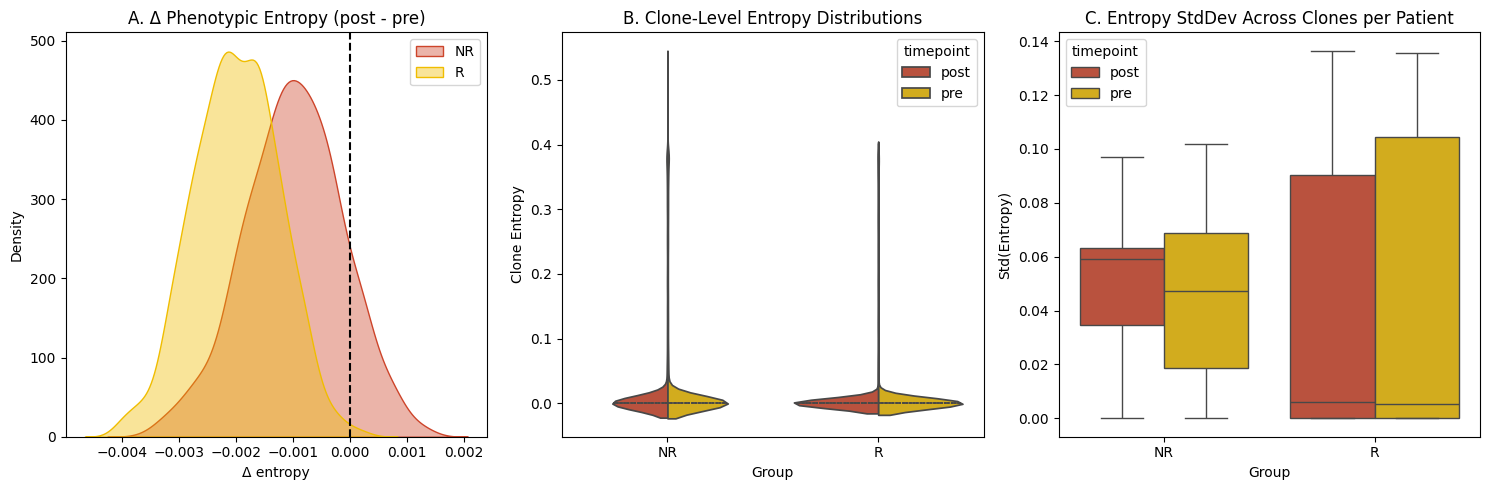

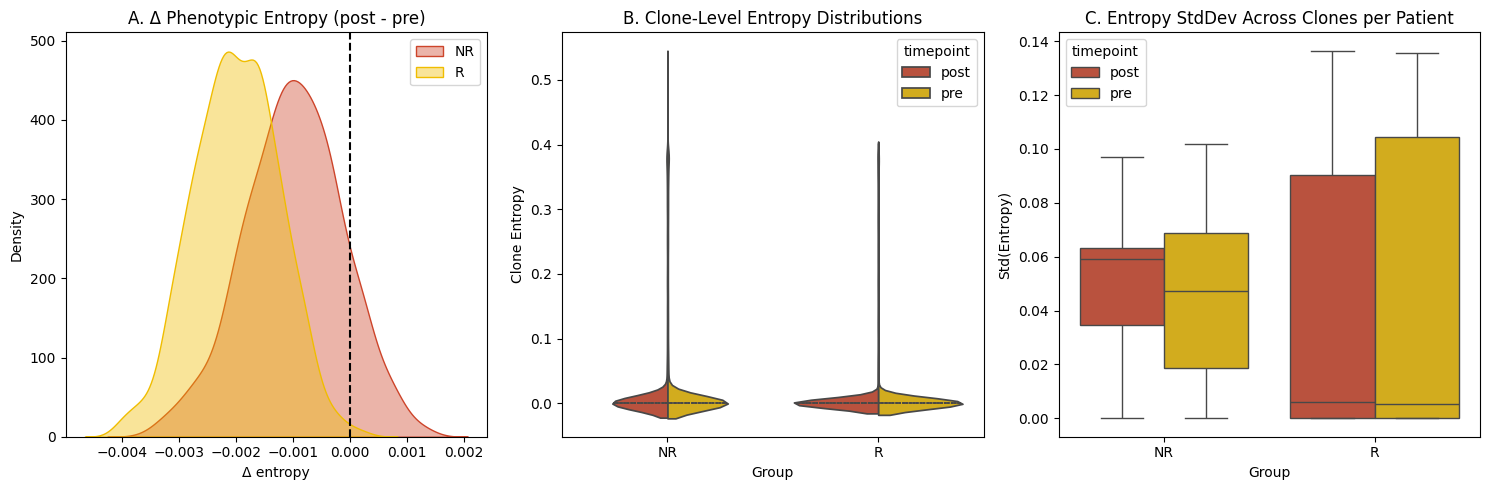

In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from tcri.pl import tcri_colors
from tcri.tl import phenotypic_entropy as pentropy
from scipy.stats import entropy


def pentropy(adata, covariate, clonotype, base=2, normalized=True, temperature=1.0, n_samples=0, clones=None):
    logf = lambda x: np.log(x) / np.log(base)
    jd = joint_distribution(adata, covariate, temperature=temperature, n_samples=n_samples, clones=clones)
    if n_samples > 0:
        jd["clonotype_id"] = ["_".join(x.split("_")[:-1]) for x in jd.index]
        jd = jd.groupby("clonotype_id").mean()
    res = jd.loc[clonotype].to_numpy()
    pent = entropy(res, base=base)
    if normalized:
        pent = pent / logf(len(res))
    return pent


def phenotypic_entropies(adata, covariate, base=2, normalized=True, temperature=1., clones=None, n_samples=0):
    tcr_sequences = adata.obs[adata.uns["tcri_clone_key"]].tolist()
    if clones is not None:
        tcr_sequences = [x for x in tcr_sequences if x in clones]
    unique_tcrs = np.unique(tcr_sequences)
    tcr_to_entropy_dict = {
        tcr: pentropy(
            adata,
            covariate,
            tcr,
            base=base,
            normalized=normalized,
            temperature=temperature,
            n_samples=n_samples
        )
        for tcr in unique_tcrs
    }
    return tcr_to_entropy_dict


def phenotypic_entropy(
    adata,
    splitby=None,
    temperature=1,
    n_samples=0,
    normalized=True,
    return_df=True,
):
    cov_col = adata.uns["tcri_metadata"]["covariate_col"]
    clone_col = adata.uns["tcri_metadata"]["clone_col"]
    phenotype_col = adata.uns["tcri_metadata"]["phenotype_col"]
    batch_col = adata.uns["tcri_metadata"]["batch_col"]

    covs = adata.obs[cov_col].astype("category").cat.categories.tolist()

    ent_vals, ps, ts, splits, clones = [], [], [], [], []

    if splitby:
        split_levels = sorted(adata.obs[splitby].dropna().unique().tolist())
    else:
        split_levels = [None]

    for s in tqdm.tqdm(split_levels, desc="Computing phenotypic entropy"):
        adata_sub = adata[adata.obs[splitby] == s] if s is not None else adata

        for p in adata_sub.obs[batch_col].unique():
            sub = adata_sub[adata_sub.obs[batch_col] == p].copy()
            for t in covs:
                subt = sub[sub.obs[cov_col] == t]
                vclones = list(set(subt.obs[clone_col]))
                if len(vclones) == 0:
                    continue
                for _ in range(n_samples):
                    entropy_dict = phenotypic_entropies(
                        subt, t,
                        temperature=temperature,
                        clones=vclones,
                        n_samples=1,
                        normalized=normalized
                    )
                    for c, v in entropy_dict.items():
                        ent_vals.append(v)
                        ps.append(p)
                        ts.append(t)
                        splits.append(s)
                        clones.append(c)

    df = pd.DataFrame({
        "Phenotypic Entropy": ent_vals,
        "patient": ps,
        "timepoint": ts,
        "clone": clones,
        "Group": splits if splitby else ["All"] * len(ent_vals)
    })

    return df


def plot_entropy_panels(df, cov_col="timepoint", group_col="Group", n_bootstrap=1000):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Panel A: Posterior Δ entropy
    groups = df[group_col].unique()
    for g in groups:
        d1 = df[(df[group_col] == g) & (df[cov_col] == "pre")]["Phenotypic Entropy"].values
        d2 = df[(df[group_col] == g) & (df[cov_col] == "post")]["Phenotypic Entropy"].values
        boot1 = np.random.choice(d1, (n_bootstrap, len(d1)), replace=True).mean(axis=1)
        boot2 = np.random.choice(d2, (n_bootstrap, len(d2)), replace=True).mean(axis=1)
        delta = boot2 - boot1
        sns.kdeplot(delta, fill=True, ax=axs[0], label=g, alpha=0.4)

    axs[0].axvline(0, color="k", linestyle="--")
    axs[0].set_title("A. Δ Phenotypic Entropy (post - pre)")
    axs[0].set_xlabel("Δ entropy")
    axs[0].legend()

    # Panel B: Clone-level violin plot
    sns.violinplot(
        data=df,
        x=group_col,
        y="Phenotypic Entropy",
        hue=cov_col,
        split=True,
        inner="quartile",
        ax=axs[1]
    )
    axs[1].set_title("B. Clone-Level Entropy Distributions")
    axs[1].set_xlabel(group_col)
    axs[1].set_ylabel("Clone Entropy")

    # Panel C: Entropy SD across clones per patient
    sd_df = (
        df.groupby([group_col, cov_col, "patient"])
        .agg(std_entropy=("Phenotypic Entropy", "std"))
        .reset_index()
    )
    sns.boxplot(data=sd_df, x=group_col, y="std_entropy", hue=cov_col, ax=axs[2])
    axs[2].set_title("C. Entropy StdDev Across Clones per Patient")
    axs[2].set_ylabel("Std(Entropy)")

    fig.tight_layout()
    return fig

df = phenotypic_entropy(
    adata,
    splitby="response",
    temperature=0.1,
    n_samples=100,
    normalized=True,
    return_df=True
)

plot_entropy_panels(df)

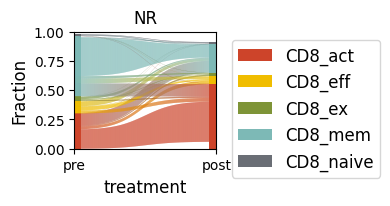

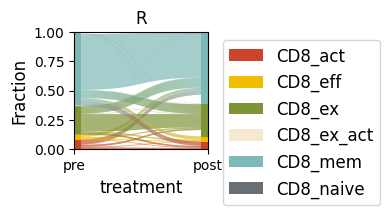

In [179]:
def phenotypic_flux(
    adata,
    splitby,
    order,
    clones=None,
    normalize=True,
    nt=False,
    n_samples=0,
    phenotype_colors=None,
    save=None,
    figsize=(4, 2),
    show_legend=True,
    temperature=1,
    phenotype_subset=None,
    title=""
):
    import collections
    import numpy as np
    import matplotlib.pyplot as plt

    all_phenotypes = adata.uns["tcri_phenotype_categories"]
    if phenotype_subset is None:
        phenotype_subset = all_phenotypes

    phenotypes = Phenotypes(phenotype_subset)  # ✅ subset phenotype space
    cell_probabilities = collections.defaultdict(dict)

    for s in order:
        jd = joint_distribution(adata, s, n_samples=n_samples, temperature=temperature)
        if n_samples > 0:
            jd["clonotype_id"] = ["_".join(x.split("_")[:-1]) for x in jd.index]
            jd = jd.groupby("clonotype_id").mean()
        for x in jd.T:
            raw_counts = jd.T[x].to_dict()
            filtered_counts = {k: v for k, v in raw_counts.items() if k in phenotype_subset}  # ✅ subset
            cell_probabilities[s][x] = filtered_counts

    repertoires = {}
    times = list(range(len(order)))
    chains_to_use = "ntseq" if nt else "aaseq"

    for s in order:
        repertoires[s] = CellRepertoire(
            clones_and_phenos={},
            phenotypes=phenotypes,
            use_genes=False,
            use_chain=False,
            seq_type=chains_to_use,
            chains_to_use=['TRB'],
            name=s
        )

    for bc, condition, seq, phenotype in zip(
        adata.obs.index,
        adata.obs[splitby],
        adata.obs[adata.uns["tcri_clone_key"]],
        adata.obs[adata.uns["tcri_phenotype_key"]]
    ):
        if str(seq) != "nan" and condition in repertoires and seq in cell_probabilities[condition]:
            phenotypes_and_counts = cell_probabilities[condition][seq]
            phenotypes_and_counts = {k: v for k, v in phenotypes_and_counts.items() if k in phenotype_subset}  # ✅ filter
            if nt:
                t = Tcell(
                    phenotypes=phenotypes,
                    phenotypes_and_counts=phenotypes_and_counts,
                    TRB=dict(ntseq=seq),
                    use_genes=False
                )
            else:
                t = Tcell(
                    phenotypes=phenotypes,
                    phenotypes_and_counts=phenotypes_and_counts,
                    TRB=dict(aaseq=seq),
                    use_genes=False
                )
            repertoires[condition].cell_list.append(t)

    for condition, rep in repertoires.items():
        rep._set_consistency()

    if phenotype_colors is None:
        phenotype_colors = dict(zip(phenotype_subset, tcri_colors[:len(phenotype_subset)]))
    else:
        # subset to selected phenotypes only
        phenotype_colors = {k: v for k, v in phenotype_colors.items() if k in phenotype_subset}

    fig, ax = plot_pheno_sankey(
        phenotypes=phenotypes,
        cell_repertoires=[repertoires[condition] for condition in order],
        clones=clones,
        times=times,
        xlim=[min(times), max(times)],
        time_rescale=1,
        normalize=normalize,
        xlabel=splitby,
        return_axes=True,
        show_legend=show_legend,
        figsize=figsize,
        phenotype_colors=phenotype_colors
    )

    ax.set_xticks(times)
    ax.set_xticklabels(order)
    ax.set_title(title)

    if save is not None:
        fig.savefig(save)

# for d in set(adata.obs["disease"]):
#     data = adata[adata.obs['disease'] == d].copy()
for x in set(adata.obs["response"]):
    phenos = ['CD8_act', 'CD8_eff', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_naive']
    colors = dict(zip(phenos,tcri_colors))
    colors["CD8_mem"] = "#7DB9B6"
    colors["CD8_ex_act"] = "#F5E9CF"
    cdata = data[data.obs["response"] == x].copy()
    if x == "NR":
        phenos.remove("CD8_ex_act")
    phenotypic_flux(cdata,"treatment",["pre","post"],temperature=1.5,phenotype_subset=phenos,title=x, phenotype_colors=colors,save="resp_{}.pdf".format(x))